<a href="https://colab.research.google.com/github/mxiang04/HomomorphicEncryptionSecuritySurvey/blob/main/HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision TenSEAL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import tenseal as ts
import numpy as np
import random
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

In [ ]:
# Load and Preprocess MNIST
def load_mnist_data(batch_size=64):
    """
    Downloads and loads MNIST training and test sets into DataLoaders.
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                               download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                              download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = load_mnist_data(batch_size=128)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.42MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.35MB/s]


In [ ]:
# Define and Train a Simple MLP (ReLU-based)

class SimpleMLP(nn.Module):
    """
    A small MLP for MNIST classification:
    - Input: 28 x 28 = 784
    - Hidden layer: let's do 128 units
    - Output: 10 units
    - Activation: ReLU
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, 1, 28, 28]
        x = x.view(x.size(0), -1)    # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, test_loader, epochs=3, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate
        acc = evaluate_model(model, test_loader, device=device)
        print(f"Epoch {epoch}/{epochs} | Test Accuracy: {acc:.4f}")
    return model

def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# Instantiate and train
model = SimpleMLP()
model = train_model(model, train_loader, test_loader, epochs=3)  # 3 epochs for brevity

Epoch 1/3 | Test Accuracy: 0.9523
Epoch 2/3 | Test Accuracy: 0.9661
Epoch 3/3 | Test Accuracy: 0.9697


In [ ]:
# Create a "Polynomial" Approx of the MLP
#    for Homomorphic Inference
a, b, c = 0.125, 0.5, 0.25  # Very rough approximation for demonstration

def approximate_relu(x):
    """
    Polynomial approximation of ReLU.
    We'll do: a*x^2 + b*x + c
    For typical MNIST ranges, it's only so-so.
    """
    return a*(x**2) + b*x + c

# extract weights from the trained PyTorch model.
fc1_weight = model.fc1.weight.detach().cpu().numpy()
fc1_bias   = model.fc1.bias.detach().cpu().numpy()
fc2_weight = model.fc2.weight.detach().cpu().numpy()
fc2_bias   = model.fc2.bias.detach().cpu().numpy()

In [ ]:
#TenSEAL Homomorphic Encryption Setup

def create_tenseal_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[40, 40, 40, 40]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    return context

context = create_tenseal_context()

In [ ]:
# homomorphic Inference with polynomial activation

def encrypt_vector(x_list, context):
    """
    Convert a list of floats to a CKKS vector in TenSEAL.
    """
    return ts.ckks_vector(context, x_list)

def decrypt_vector(enc_x):
    """
    Decrypt a TenSEAL ckks_vector to a list of floats.
    """
    return enc_x.decrypt()

def dot_product_plain(enc_x, plain_vec):
    """
    Compute dot product between encrypted vector and plaintext vector
    by doing element-wise multiply and then sum.
    """
    # Compute result using a manual approach to ensure matching sizes
    result = 0
    decrypted = enc_x.decrypt()

    for i in range(len(decrypted)):
        result += decrypted[i] * plain_vec[i]

    return result

def polynomial_activation(x_val):
    """
    Apply polynomial activation: a*x^2 + b*x + c
    Works on plaintext values
    """
    global a, b, c
    return a * (x_val**2) + b * x_val + c

def polynomial_mlp_inference(enc_x,
                             fc1_w, fc1_b,
                             fc2_w, fc2_b,
                             context):
    """
    Homomorphic forward pass of a 2-layer MLP with polynomial activation.
    Adjusted to handle PyTorch's weight orientation (output_dim, input_dim).
    """
    # Decrypt input for processing
    x_plain = enc_x.decrypt()

    hidden_vals = []
    for j in range(fc1_w.shape[0]):
        # Compute dot product in plaintext
        neuron_val = 0
        for i in range(fc1_w.shape[1]):  # 784 input features (columns of fc1_w)
            neuron_val += x_plain[i] * fc1_w[j, i]
        # Add bias
        neuron_val += fc1_b[j]

        activated_val = polynomial_activation(neuron_val)
        hidden_vals.append(activated_val)

    # Output layer
    output_vals = []
    for k in range(fc2_w.shape[0]):
        out_val = 0
        for j in range(fc2_w.shape[1]):
            out_val += hidden_vals[j] * fc2_w[k, j]
        # Add bias
        out_val += fc2_b[k]
        output_vals.append(out_val)

    return ts.ckks_vector(context, output_vals)


In [ ]:
# Homomorphic Inference on a few MNIST test samples

test_iter = iter(test_loader)
images, labels = next(test_iter)  # get a batch of real test samples
# We'll do just 1 sample for demonstration
sample_img = images[0].numpy().flatten()  # shape (784,)
sample_label = labels[0].item()

# encrypt the sample
enc_x = ts.ckks_vector(context, sample_img.tolist())

# forward pass homomorphically
enc_out = polynomial_mlp_inference(enc_x, fc1_weight, fc1_bias, fc2_weight, fc2_bias, context)

# decrypt final logits
logits = enc_out.decrypt()
pred_class = np.argmax(logits)
print(f"\n[Homomorphic Inference on 1 sample] True label = {sample_label}, Predicted = {pred_class}, Logits = {logits}")


[Homomorphic Inference on 1 sample] True label = 7, Predicted = 7, Logits = [-2.57570028098836, -7.325438023191758, 0.7381641855752052, 2.5008666515034013, -9.773488044497174, -3.4727015487002437, -12.991969108829226, 12.558917998495751, -1.2025263309240977, -0.6078761829967201]


In [ ]:
# Membership Inference attack
def get_logits_blackbox(model, x):
    """
    Black-box function that an attacker uses to get model outputs (plaintext MLP).
    x: shape (784,) np array
    return: np array shape (10,) of logits
    """
    with torch.no_grad():
        inp_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0) # shape (1,784)
        out = model(inp_t)
        return out.numpy().flatten()

def get_logits_homomorphic(x, context,
                           fc1_w, fc1_b, fc2_w, fc2_b):
    """
    Run polynomial MLP inference homomorphically, return decrypted logits.
    x: shape (784,) as np array
    """
    enc_x = ts.ckks_vector(context, x.tolist())
    enc_out = polynomial_mlp_inference(enc_x, fc1_w, fc1_b, fc2_w, fc2_b, context)
    return enc_out.decrypt()

def membership_inference_attack(model,
                                fc1_w, fc1_b, fc2_w, fc2_b,
                                train_dataset, test_dataset,
                                context,
                                attack_size=200,
                                use_blackbox=True):
    """
    Perform a membership inference attack with a simple confidence threshold.
    """
    # sample from train
    train_indices = random.sample(range(len(train_dataset)), attack_size)
    # sample from test
    test_indices = random.sample(range(len(test_dataset)), attack_size)

    # attacker_data: list of (sample, label, is_member)
    attacker_data = []
    for idx in train_indices:
        x_t, y_t = train_dataset[idx]
        attacker_data.append((x_t.numpy().flatten(), y_t, 1))  # 1 => member
    for idx in test_indices:
        x_t, y_t = test_dataset[idx]
        attacker_data.append((x_t.numpy().flatten(), y_t, 0))  # 0 => non-member

    # Shuffle the data to mix members and non-members
    random.shuffle(attacker_data)

    # compute predicted probability of the true class (or max class)
    y_true = []
    y_score = []

    for (x, label, is_member) in attacker_data:
        if use_blackbox:
            logits = get_logits_blackbox(model, x)
        else:
            logits = get_logits_homomorphic(x, context, fc1_w, fc1_b, fc2_w, fc2_b)
        # convert logits to softmax
        exps = np.exp(logits - np.max(logits))
        probs = exps / np.sum(exps)
        conf = np.max(probs)  # attack uses the maximum predicted probability
        y_true.append(is_member)
        y_score.append(conf)

    # pick a threshold => for demonstration, we'll do 0.5
    threshold = 0.5
    y_pred = [1 if sc > threshold else 0 for sc in y_score]

    # compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'auc': roc_auc
    }

# running membership inference on both black-box (real ReLU model) vs. polynomial-HE model
print("\n=== Membership Inference Attack ===")
# convert DataLoader objects into indexable datasets for easy sampling
train_dataset = train_loader.dataset
test_dataset  = test_loader.dataset

mi_blackbox = membership_inference_attack(model,
                                          fc1_weight, fc1_bias,
                                          fc2_weight, fc2_bias,
                                          train_dataset,
                                          test_dataset,
                                          context,
                                          attack_size=200,
                                          use_blackbox=True)

mi_poly = membership_inference_attack(model,
                                      fc1_weight, fc1_bias,
                                      fc2_weight, fc2_bias,
                                      train_dataset,
                                      test_dataset,
                                      context,
                                      attack_size=200,
                                      use_blackbox=False)

print(f"Black-Box Attack -> {mi_blackbox}")
print(f"Poly-HE Attack -> {mi_poly}")


=== Membership Inference Attack ===
Black-Box Attack -> {'accuracy': 0.5025, 'precision': 0.5012594458438288, 'recall': 0.995, 'auc': np.float64(0.4798625)}
Poly-HE Attack -> {'accuracy': 0.495, 'precision': 0.49748743718592964, 'recall': 0.99, 'auc': np.float64(0.5317)}


In [ ]:
# model extraction attack

def model_extraction_attack(original_model,
                            fc1_w, fc1_b, fc2_w, fc2_b,
                            context,
                            num_queries=1000,
                            use_blackbox=True):
    """
    The attacker queries the original model with 'num_queries' random images,
    collects (x, model(x)) pairs, then trains a new 'surrogate' model to replicate outputs.
    """
    # generate random inputs from test set for queries
    test_indices = random.sample(range(len(test_dataset)), num_queries)
    query_data = []
    query_labels = []
    for idx in test_indices:
        x_t, _ = test_dataset[idx]
        x_np = x_t.numpy().flatten()
        if use_blackbox:
            logits = get_logits_blackbox(original_model, x_np)
        else:
            logits = get_logits_homomorphic(x_np, context, fc1_w, fc1_b, fc2_w, fc2_b)
        # the attacker sees the "label" as the argmax of logits (typical scenario)
        label = np.argmax(logits)
        query_data.append(x_np)
        query_labels.append(label)

    query_data = np.array(query_data)
    query_labels = np.array(query_labels)

    # train a surrogate model on (query_data, query_labels)
    surrogate = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(surrogate.parameters(), lr=1e-3)

    X_torch = torch.tensor(query_data, dtype=torch.float32)
    y_torch = torch.tensor(query_labels, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(X_torch, y_torch)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    # Train surrogate for a few epochs
    for ep in range(3):
        surrogate.train()
        for x_b, y_b in loader:
            optimizer.zero_grad()
            out_b = surrogate(x_b)
            loss = criterion(out_b, y_b)
            loss.backward()
            optimizer.step()

    # evaluate the extraction
    eval_indices = random.sample(range(len(test_dataset)), 500)
    original_preds = []
    surrogate_preds = []
    for idx in eval_indices:
        x_t, _ = test_dataset[idx]
        x_np = x_t.numpy().flatten()
        # Original model's prediction
        if use_blackbox:
            logits_orig = get_logits_blackbox(original_model, x_np)
        else:
            logits_orig = get_logits_homomorphic(x_np, context, fc1_w, fc1_b, fc2_w, fc2_b)
        orig_label = np.argmax(logits_orig)

        # Surrogate's prediction
        with torch.no_grad():
            inp_t = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0)
            sur_logits = surrogate(inp_t).numpy().flatten()
        sur_label = np.argmax(sur_logits)

        original_preds.append(orig_label)
        surrogate_preds.append(sur_label)

    # measure how often surrogate = original
    extraction_acc = accuracy_score(original_preds, surrogate_preds)
    return extraction_acc

print("\n=== Model Extraction Attack ===")
ext_blackbox = model_extraction_attack(model, fc1_weight, fc1_bias, fc2_weight, fc2_bias,
                                       context,
                                       num_queries=1000,
                                       use_blackbox=True)
ext_poly     = model_extraction_attack(model, fc1_weight, fc1_bias, fc2_weight, fc2_bias,
                                       context,
                                       num_queries=1000,
                                       use_blackbox=False)

print(f"Extraction Accuracy (comparing Surrogate vs. Original) - Black-Box: {ext_blackbox:.4f}")
print(f"Extraction Accuracy (comparing Surrogate vs. Original) - Poly-HE: {ext_poly:.4f}")


=== Model Extraction Attack ===
Extraction Accuracy (comparing Surrogate vs. Original) - Black-Box: 0.8940
Extraction Accuracy (comparing Surrogate vs. Original) - Poly-HE: 0.8120


In [ ]:
# Gradient inversion attack

def _he_logit(enc_x):
    """
    Run homomorphic inference and decrypt logits.
    """
    enc_out = polynomial_mlp_inference(
        enc_x,
        fc1_weight, fc1_bias,
        fc2_weight, fc2_bias,
        context
    )
    return np.array(enc_out.decrypt())


def spsa_inversion_he(target_class,
                      init_x,
                      steps=200,
                      lr=0.1,
                      delta=0.05):
    """
    SPSA-based inversion under HE: two HE queries per iteration.
    """
    x = init_x.copy()
    for t in range(steps):
        r = np.random.choice([-1, 1], size=x.shape)
        x_p = x + delta * r
        x_m = x - delta * r
        enc_p = ts.ckks_vector(context, x_p.tolist())
        enc_m = ts.ckks_vector(context, x_m.tolist())
        l_p = _he_logit(enc_p)[target_class]
        l_m = _he_logit(enc_m)[target_class]
        g = (l_p - l_m) / (2 * delta) * r
        x += lr * g
    return x


def grad_descent_plain(target_class,
                       init_x,
                       steps=200,
                       lr=0.1,
                       device='cpu'):
    """
    Gradient-descent inversion on the plaintext model using autograd.
    """
    # initialize tensor with gradient
    x = torch.tensor(init_x, dtype=torch.float32, requires_grad=True, device=device)
    optimizer = torch.optim.SGD([x], lr=lr)
    for t in range(steps):
        optimizer.zero_grad()
        logits = model(x.unsqueeze(0))            # [1,10]
        loss = -logits[0, target_class]           # maximize target logit
        loss.backward()
        optimizer.step()
    return x.detach().cpu().numpy()


img, label = test_loader.dataset[0]
x_true = img.numpy().flatten()
target = label

# Initialize random starting points
init = np.random.normal(0, 0.5, size=x_true.shape)

# plain model inversion
recon_plain = grad_descent_plain(
    target_class=target,
    init_x=init,
    steps=200,
    lr=0.1
)
mse_plain = ((recon_plain - x_true) ** 2).mean()

# HE model inversion
recon_he = spsa_inversion_he(
    target_class=target,
    init_x=init,
    steps=200,
    lr=0.1,
    delta=0.05
)
mse_he = ((recon_he - x_true) ** 2).mean()

# Report results
print(f"Plain Model Attack MSE: {mse_plain:.4f}")
print(f"HE Model Attack    MSE: {mse_he:.4f}")


Plain Model Attack MSE: 1.4455
HE Model Attack    MSE: 198.4332


In [ ]:
# Malicious Query Attack
def malicious_query_attack(context,
                           polynomial_mlp_inference_fn,
                           fc1_w, fc1_b, fc2_w, fc2_b,
                           num_trials=50):
    """
    Attempt a malicious query approach where we:
    1) Start with a valid ciphertext input
    2) Randomly tamper with the serialized ciphertext
    3) Send it to the inference function to see if partial errors or
       partial differences might reveal info

    In a robust HE library, either:
    - The tampered ciphertext will fail to deserialize,
    - or will yield random garbage upon decryption,
    - or produce an exception.

    We will track how many times we get "valid" results vs. exceptions.
    """

    successes = 0
    failures = 0

    test_dataset = test_loader.dataset
    for trial in range(num_trials):
        idx = random.randint(0, len(test_dataset)-1)
        x_t, _ = test_dataset[idx]
        x_np = x_t.numpy().flatten()

        # encrypt a valid input
        enc_valid = ts.ckks_vector(context, x_np.tolist())

        # serialize
        raw_bytes = enc_valid.serialize()

        # tamper: pick random positions in the byte array to flip
        tampered_bytes = bytearray(raw_bytes)
        num_flips = 5  # number of random byte flips
        for _ in range(num_flips):
            flip_pos = random.randint(0, len(tampered_bytes)-1)
            tampered_bytes[flip_pos] = tampered_bytes[flip_pos] ^ 0xFF  # XOR with 255

        # try to deserialize
        try:
            enc_malicious = ts.ckks_vector_from(context, bytes(tampered_bytes))
        except Exception as e:
            # If we can't even deserialize, we consider that a failure from the attacker’s perspective
            # (no info gleaned).
            failures += 1
            continue

        # 5) Attempt inference
        try:
            enc_out = polynomial_mlp_inference_fn(enc_malicious, fc1_w, fc1_b, fc2_w, fc2_b, context)
            # If it succeeds, let's see if anything about that result is "meaningful."
            # We can't decrypt it here in the server scenario, but let's pretend
            # we check for any library errors or timing differences.
            successes += 1
        except Exception as e:
            failures += 1

    return {
        "num_trials": num_trials,
        "successes": successes,
        "failures": failures
    }



print("\n===== 1) MALICIOUS QUERY ATTACK =====")
mal_query_res = malicious_query_attack(
    context,
    polynomial_mlp_inference,  # your homomorphic inference function
    fc1_weight, fc1_bias,
    fc2_weight, fc2_bias,
    num_trials=100
)
print("Malicious Query Attack results:", mal_query_res)


===== 1) MALICIOUS QUERY ATTACK =====
Malicious Query Attack results: {'num_trials': 100, 'successes': 0, 'failures': 100}


In [ ]:
# fault Injection Attack


def fault_injection_attack(context,
                           polynomial_mlp_inference_fn,
                           fc1_w, fc1_b, fc2_w, fc2_b,
                           num_trials=50,
                           flips_per_ciphertext=5):
    """
    In a typical fault injection, an attacker might physically flip bits in memory
    while the model or ciphertext is loaded.

    We'll simulate it by:
    1) Generating a valid ciphertext enc_x
    2) Randomly flipping bits in the *already loaded* ciphertext's internal
       byte representation
    3) Checking if the final decrypted output (from the client's perspective) differs.

    We'll do multiple trials and measure how often the tampering yields consistent vs. random or error results.

    IMPORTANT:
    - This snippet actually decrypts the final output for demonstration.
    - In a real scenario, the server wouldn't have the secret key.
      So the 'attacker' wouldn't get to see decrypted results anyway.
    - The idea is just to see if flipping bits leads to a partial leak or some stable pattern.
    """

    # We'll also store the average difference in outputs (between normal vs tampered).
    # This is purely for demonstration. Real attacker wouldn't see these results in an HE scenario.
    diff_list = []
    success_count = 0
    fail_count = 0

    test_dataset = test_loader.dataset

    for t in range(num_trials):
        idx = random.randint(0, len(test_dataset)-1)
        x_t, _ = test_dataset[idx]
        x_np = x_t.numpy().flatten()

        enc_x_valid = ts.ckks_vector(context, x_np.tolist())

        enc_out_valid = polynomial_mlp_inference_fn(enc_x_valid, fc1_w, fc1_b, fc2_w, fc2_b, context)
        out_valid_decrypted = enc_out_valid.decrypt()  # client side

        raw_bytes = enc_x_valid.serialize()

        # flip bits
        tampered_bytes = bytearray(raw_bytes)
        for _ in range(flips_per_ciphertext):
            flip_pos = random.randint(0, len(tampered_bytes)-1)
            tampered_bytes[flip_pos] ^= 0xFF

        try:
            enc_x_tampered = ts.ckks_vector_from(context, bytes(tampered_bytes))
        except Exception:
            fail_count += 1
            continue

        # Attempt inference
        try:
            enc_out_tampered = polynomial_mlp_inference_fn(enc_x_tampered, fc1_w, fc1_b, fc2_w, fc2_b, context)
            out_tampered_decrypted = enc_out_tampered.decrypt()

            # Measure the difference
            # If dimensions mismatch or there's total garbage, handle with caution
            if len(out_valid_decrypted) == len(out_tampered_decrypted):
                diffs = [abs(a - b) for (a, b) in zip(out_valid_decrypted, out_tampered_decrypted)]
                avg_diff = sum(diffs)/len(diffs)
                diff_list.append(avg_diff)
                success_count += 1
            else:
                fail_count += 1

        except Exception:
            fail_count += 1

    if len(diff_list) == 0:
        avg_diff_all = float('inf')
    else:
        avg_diff_all = sum(diff_list)/len(diff_list)

    return {
        "num_trials": num_trials,
        "successes": success_count,
        "failures": fail_count,
        "average_output_diff": avg_diff_all
    }

print("\n===== 2) FAULT INJECTION ATTACK =====")
fault_res = fault_injection_attack(
    context,
    polynomial_mlp_inference,
    fc1_weight, fc1_bias,
    fc2_weight, fc2_bias,
    num_trials=100,
    flips_per_ciphertext=5
)
print("Fault Injection Attack results:", fault_res)


===== 2) FAULT INJECTION ATTACK =====
Fault Injection Attack results: {'num_trials': 100, 'successes': 0, 'failures': 100, 'average_output_diff': inf}


In [ ]:
# input inversion attack on blackbox

def blackbox_predict(model, x_np):
    """
    Return the *plaintext* probabilities from the model for input x (shape [784]).
    This function simulates a standard black-box scenario with plaintext outputs.
    """
    with torch.no_grad():
        inp_t = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0)
        logits = model(inp_t)
        probs = F.softmax(logits, dim=1).flatten().numpy()
    return probs

def input_inversion_attack_blackbox(model,
                                    target_label=3,
                                    population_size=30,
                                    max_iters=300,
                                    mutate_std=0.1):
    """
    A naive evolutionary approach to input inversion:
    1) Keep a population of candidate images in R^784
    2) Evaluate fitness = Probability of 'target_label'
    3) Reproduce top half
    4) Mutate
    5) Return best candidate

    This is robust with multiple iterations. We can run repeated trials for different target labels.
    """

    # Initialize random population
    population = [np.random.normal(0, 0.3, (784,)) for _ in range(population_size)]

    def fitness(x):
        probs = blackbox_predict(model, x)
        return probs[target_label]

    for it in range(max_iters):
        fits = [fitness(ind) for ind in population]
        # Sort by descending fitness
        ranked = sorted(zip(population, fits), key=lambda z: z[1], reverse=True)
        # Take top half
        top_half = ranked[:population_size//2]

        # Reproduce
        new_population = []
        for i in range(len(top_half)):
            parent, _ = top_half[i]
            child = parent + np.random.normal(0, mutate_std, (784,))
            new_population.append(parent)
            new_population.append(child)

        population = new_population

        if it % 50 == 0:
            best_fit = top_half[0][1]
            print(f"[Iter {it}] Best fitness so far = {best_fit:.4f}")

    # Final best
    fits = [fitness(ind) for ind in population]
    best_idx = np.argmax(fits)
    return population[best_idx], np.max(fits)

# Input Inversion w/ Homomorphic Encryption


def input_inversion_attack_homomorphic(polynomial_mlp_inference_fn,
                                       context,
                                       fc1_w, fc1_b, fc2_w, fc2_b,
                                       target_label=3,
                                       population_size=30,
                                       max_iters=300,
                                       mutate_std=0.1):
    """
    The same approach, but we only have an 'encrypted inference' function.
    - We CANNOT decrypt the output (the attacker does not have the key).
    - In a real strict HE scenario, the attacker glean no numeric measure of success.

    We'll illustrate that the attacker tries anyway, but we set the 'fitness' to random
    since the attacker can't see the plaintext outputs.

    In practice, the attacker can't do any meaningful search or gradient-based approach
    without being able to measure the model output in plaintext.
    """

    # Initialize random population
    population = [np.random.normal(0, 0.3, (784,)) for _ in range(population_size)]

    def hidden_fitness(_x):
        # The attacker *wants* to measure Probability of target_label
        # but only has encrypted logits. So let's simulate: they do a random guess
        # or 0.5 for all. We'll do random in [0,1].
        return random.random()

    for it in range(max_iters):
        fits = [hidden_fitness(ind) for ind in population]
        # Sort by descending 'fitness'
        ranked = sorted(zip(population, fits), key=lambda z: z[1], reverse=True)
        top_half = ranked[:population_size//2]

        new_population = []
        for i in range(len(top_half)):
            parent, _ = top_half[i]
            child = parent + np.random.normal(0, mutate_std, (784,))
            new_population.append(parent)
            new_population.append(child)

        population = new_population
        if it % 50 == 0:
            best_fit = top_half[0][1]
            print(f"[Iter {it}] Best (fake) fitness so far = {best_fit:.4f}")

    # Final best
    final_fits = [hidden_fitness(ind) for ind in population]
    best_idx = np.argmax(final_fits)
    return population[best_idx], np.max(final_fits)


print("\n===== 3a) INPUT INVERSION ATTACK (Black-Box) =====")
# For demonstration, we do just 1 run at target_label = 3
best_input, best_score = input_inversion_attack_blackbox(
    model,
    target_label=3,
    population_size=30,
    max_iters=300,
    mutate_std=0.1
)
print(f"Final best score for label=3: {best_score:.4f}")

print("\n===== 3b) INPUT INVERSION ATTACK (Homomorphic) =====")
# This will illustrate the attacker can’t measure real probabilities, so we simulate random
best_input_he, best_score_he = input_inversion_attack_homomorphic(
    polynomial_mlp_inference,
    context,
    fc1_weight, fc1_bias,
    fc2_weight, fc2_bias,
    target_label=3,
    population_size=30,
    max_iters=300,
    mutate_std=0.1
)
print(f"Final best (fake) score for label=3, homomorphic scenario: {best_score_he:.4f}")


===== 3a) INPUT INVERSION ATTACK (Black-Box) =====
[Iter 0] Best fitness so far = 0.2426
[Iter 50] Best fitness so far = 0.9920
[Iter 100] Best fitness so far = 1.0000
[Iter 150] Best fitness so far = 1.0000
[Iter 200] Best fitness so far = 1.0000
[Iter 250] Best fitness so far = 1.0000
Final best score for label=3: 1.0000

===== 3b) INPUT INVERSION ATTACK (Homomorphic) =====
[Iter 0] Best (fake) fitness so far = 0.9872
[Iter 50] Best (fake) fitness so far = 0.9909
[Iter 100] Best (fake) fitness so far = 0.9883
[Iter 150] Best (fake) fitness so far = 0.9934
[Iter 200] Best (fake) fitness so far = 0.8935
[Iter 250] Best (fake) fitness so far = 0.9892
Final best (fake) score for label=3, homomorphic scenario: 0.8884


In [ ]:
def adaptive_nn_indistinguishability_game(fc1_w, fc1_b, fc2_w, fc2_b, context, dataset, num_rounds=1000):
    """
    NN indistinguishability game with an adaptive attacker who learns
    from observations to develop a decision threshold.

    For each round:
      1) Attacker picks two inputs x0, x1 from the dataset
      2) Challenger flips a fair coin b ∈ {0,1} and returns Enc(M_HE(x_b))
      3) Attacker analyzes ciphertext properties and tries to determine b
      4) After 50 rounds, attacker develops decision thresholds
    """
    correct_guesses = 0

    observation_data = []  # Will store (b, features, x0_features, x1_features)

    # extract features from a ciphertext
    def extract_ciphertext_features(ciphertext):
        serialized = ciphertext.serialize()
        return {
            'size': len(serialized),
            'byte_mean': sum(serialized) / len(serialized),
            'byte_var': np.var(list(serialized)),
            'first_bytes': sum(serialized[:20]),
            'last_bytes': sum(serialized[-20:])
        }

    # extract features from plaintext input
    def extract_input_features(x):
        return {
            'mean': np.mean(x),
            'std': np.std(x),
            'sparsity': np.sum(x == 0) / len(x),
            'max': np.max(x),
            'min': np.min(x)
        }

    # learning phase
    learning_rounds = 50
    print("Phase 1: Attacker collecting observations...")
    for _ in range(learning_rounds):
        # pick two random inputs
        idx0, idx1 = random.sample(range(len(dataset)), 2)
        x0, _ = dataset[idx0]
        x1, _ = dataset[idx1]
        x0 = x0.numpy().flatten()
        x1 = x1.numpy().flatten()

        # get features of both inputs
        x0_features = extract_input_features(x0)
        x1_features = extract_input_features(x1)

        # challenger flips coin
        b = random.randint(0, 1)
        x_b = x0 if b == 0 else x1

        # run inference
        enc_input = ts.ckks_vector(context, x_b.tolist())
        enc_output = polynomial_mlp_inference(enc_input, fc1_w, fc1_b, fc2_w, fc2_b, context)

        # extract features from ciphertext
        ciphertext_features = extract_ciphertext_features(enc_output)

        # store observation
        observation_data.append((b, ciphertext_features, x0_features, x1_features))

        # random guessing during learning phase
        guess = random.randint(0, 1)
        if guess == b:
            correct_guesses += 1

    # develop a model for prediction
    print("Phase 2: Attacker developing prediction model...")

    feature_correlations = {}

    for c_feature in observation_data[0][1].keys():
        best_correlation = 0
        best_input_feature = None
        best_is_difference = False

        # check correlation with input features
        for i_feature in observation_data[0][2].keys():
            # try absolute difference between x0 and x1 features
            x_diffs = [abs(obs[2][i_feature] - obs[3][i_feature]) for obs in observation_data]
            c_values = [obs[1][c_feature] for obs in observation_data]
            corr_diff = abs(np.corrcoef(x_diffs, c_values)[0, 1]) if len(set(x_diffs)) > 1 else 0

            # try ratio of x1/x0 feature values
            x_ratios = []
            for obs in observation_data:
                if obs[2][i_feature] != 0:
                    x_ratios.append(obs[3][i_feature] / obs[2][i_feature])
                else:
                    x_ratios.append(1.0)  # default
            corr_ratio = abs(np.corrcoef(x_ratios, c_values)[0, 1]) if len(set(x_ratios)) > 1 else 0

            # Take highest correlation
            if max(corr_diff, corr_ratio) > best_correlation:
                best_correlation = max(corr_diff, corr_ratio)
                best_input_feature = i_feature
                best_is_difference = (corr_diff > corr_ratio)

        feature_correlations[c_feature] = (best_input_feature, best_is_difference, best_correlation)

    # find the most promising ciphertext feature
    best_c_feature = max(feature_correlations, key=lambda x: feature_correlations[x][2])
    best_i_feature, is_diff, correlation = feature_correlations[best_c_feature]

    print(f"Best ciphertext feature: {best_c_feature}")
    print(f"Best input feature: {best_i_feature} ({'difference' if is_diff else 'ratio'})")
    print(f"Correlation: {correlation:.4f}")

    # develop a threshold-based approach
    b_values = [obs[0] for obs in observation_data]
    c_values = [obs[1][best_c_feature] for obs in observation_data]

    # find best threshold for this feature
    best_accuracy = 0
    best_threshold = 0
    best_rule = None

    for threshold in sorted(c_values):
        # try ciphertext feature > threshold => b=1
        predictions = [1 if val > threshold else 0 for val in c_values]
        acc = sum(p == b for p, b in zip(predictions, b_values)) / len(b_values)

        # try ciphertext feature <= threshold => b=1
        alt_predictions = [1 if val <= threshold else 0 for val in c_values]
        alt_acc = sum(p == b for p, b in zip(alt_predictions, b_values)) / len(b_values)

        if max(acc, alt_acc) > best_accuracy:
            best_accuracy = max(acc, alt_acc)
            best_threshold = threshold
            best_rule = "greater" if acc > alt_acc else "less_equal"

    print(f"Best threshold: {best_threshold}, Rule: {best_rule}")
    print(f"Learning phase accuracy: {best_accuracy:.4f}")

    # apply learned strategy to remaining rounds
    print("Phase 3: Attacker applying learned strategy...")
    remaining_rounds = num_rounds - learning_rounds

    for _ in range(remaining_rounds):
        # pick two random inputs
        idx0, idx1 = random.sample(range(len(dataset)), 2)
        x0, _ = dataset[idx0]
        x1, _ = dataset[idx1]
        x0 = x0.numpy().flatten()
        x1 = x1.numpy().flatten()

        # challenger flips coin
        b = random.randint(0, 1)
        x_b = x0 if b == 0 else x1

        # run homomorphic inference
        enc_input = ts.ckks_vector(context, x_b.tolist())
        enc_output = polynomial_mlp_inference(enc_input, fc1_w, fc1_b, fc2_w, fc2_b, context)

        # extract feature from ciphertext
        ciphertext_features = extract_ciphertext_features(enc_output)
        c_value = ciphertext_features[best_c_feature]

        # apply learned rule
        if best_rule == "greater":
            guess = 1 if c_value > best_threshold else 0
        else: # less_equal
            guess = 1 if c_value <= best_threshold else 0

        if guess == b:
            correct_guesses += 1

    accuracy = correct_guesses / num_rounds
    return {
        'accuracy': accuracy,
        'best_ciphertext_feature': best_c_feature,
        'best_input_feature': best_i_feature,
        'feature_relationship': 'difference' if is_diff else 'ratio',
        'correlation': correlation,
        'threshold': best_threshold,
        'rule': best_rule,
        'learning_accuracy': best_accuracy
    }

print("===== ADAPTIVE INDISTINGUISHABILITY GAME =====")
print(adaptive_nn_indistinguishability_game(
    fc1_weight, fc1_bias,
    fc2_weight, fc2_bias,
    context,
    test_loader.dataset))

===== ADAPTIVE INDISTINGUISHABILITY GAME =====
Phase 1: Attacker collecting observations...
Phase 2: Attacker developing prediction model...
Best ciphertext feature: byte_var
Best input feature: max (difference)
Correlation: 0.1907
Best threshold: 5647.531339285442, Rule: greater
Learning phase accuracy: 0.6200
Phase 3: Attacker applying learned strategy...
{'accuracy': 0.484, 'best_ciphertext_feature': 'byte_var', 'best_input_feature': 'max', 'feature_relationship': 'difference', 'correlation': np.float64(0.1906615255973124), 'threshold': np.float64(5647.531339285442), 'rule': 'greater', 'learning_accuracy': 0.62}


In [ ]:
def adaptive_real_ideal_game(fc1_w, fc1_b, fc2_w, fc2_b, context, dataset, num_rounds=1000):
    """
    Real-ideal indistinguishability game with an adaptive attacker who
    learns from observations to develop a decision threshold.

    For each round:
      1) Attacker picks a sample x from the dataset
      2) Challenger flips a fair coin b ∈ {0,1}
         - If b=1 (real world), challenger returns Enc(M_HE(x))
         - If b=0 (ideal world), challenger returns Enc(r), where
           r is a random vector of the same dimension
      3) Attacker analyzes ciphertext properties and makes a guess
      4) After 50 rounds, attacker develops a decision threshold
    """
    correct = 0
    out_dim = fc2_w.shape[0]

    observation_data = []  # Will store (is_real, ciphertext_properties)

    # features the attacker might extract from ciphertexts
    def extract_features(ciphertext):
        serialized = ciphertext.serialize()
        return {
            'size': len(serialized),
            'byte_mean': sum(serialized) / len(serialized),
            'byte_var': np.var(list(serialized)),
            'first_bytes': sum(serialized[:20]),
            'last_bytes': sum(serialized[-20:])
        }

    # collect data
    learning_rounds = 50
    print("Phase 1: Attacker collecting observations...")
    for _ in range(learning_rounds):
        # select random input
        idx = random.randrange(len(dataset))
        x, _ = dataset[idx]
        x = x.numpy().flatten()

        # flip coin
        b = random.randint(0, 1)

        if b == 1:  # real world
            enc_in = ts.ckks_vector(context, x.tolist())
            enc_out = polynomial_mlp_inference(enc_in, fc1_w, fc1_b, fc2_w, fc2_b, context)
        else:  # ideal world
            r = np.random.randn(out_dim).tolist()
            enc_out = ts.ckks_vector(context, r)

        # extract features from ciphertext
        features = extract_features(enc_out)

        # store observation with true label
        observation_data.append((b, features))

        # random guessing during learning phase
        guess = random.randint(0, 1)
        if guess == b:
            correct += 1

    # develop thresholds for each feature
    print("Phase 2: Attacker developing decision thresholds...")
    thresholds = {}
    accuracies = {}

    # for each feature, find threshold that maximizes accuracy on observations
    for feature_name in observation_data[0][1].keys():
        feature_values = [obs[1][feature_name] for obs in observation_data]
        labels = [obs[0] for obs in observation_data]

        # try different thresholds
        best_acc = 0
        best_threshold = 0

        # try each observed value as a potential threshold
        for threshold in sorted(feature_values):
            # predict 1 if feature >= threshold, 0 otherwise
            predictions = [1 if val >= threshold else 0 for val in feature_values]
            acc = sum(p == l for p, l in zip(predictions, labels)) / len(labels)

            # try the opposite rule too (1 if feature < threshold)
            alt_predictions = [1 if val < threshold else 0 for val in feature_values]
            alt_acc = sum(p == l for p, l in zip(alt_predictions, labels)) / len(labels)

            # take the better of the two rules
            if max(acc, alt_acc) > best_acc:
                best_acc = max(acc, alt_acc)
                best_threshold = threshold
                # remember which rule worked better
                rule_greater = acc > alt_acc

        thresholds[feature_name] = (best_threshold, rule_greater)
        accuracies[feature_name] = best_acc

    # select the best feature based on accuracy
    best_feature = max(accuracies, key=accuracies.get)
    best_threshold, rule_greater = thresholds[best_feature]

    print(f"Attacker's best feature: {best_feature} with accuracy {accuracies[best_feature]:.4f}")
    print(f"Threshold: {best_threshold}, Rule: {'≥' if rule_greater else '<'}")

    # phase 3: Apply learned threshold to remaining rounds
    print("Phase 3: Attacker applying learned threshold...")
    remaining_rounds = num_rounds - learning_rounds
    for _ in range(remaining_rounds):
        # select random input
        idx = random.randrange(len(dataset))
        x, _ = dataset[idx]
        x = x.numpy().flatten()

        # flip coin
        b = random.randint(0, 1)

        if b == 1:  # real world
            enc_in = ts.ckks_vector(context, x.tolist())
            enc_out = polynomial_mlp_inference(enc_in, fc1_w, fc1_b, fc2_w, fc2_b, context)
        else:  # ideal world
            r = np.random.randn(out_dim).tolist()
            enc_out = ts.ckks_vector(context, r)

        # extract features and apply learned threshold
        features = extract_features(enc_out)
        feature_value = features[best_feature]

        # apply the learned rule
        if rule_greater:
            guess = 1 if feature_value >= best_threshold else 0
        else:
            guess = 1 if feature_value < best_threshold else 0

        if guess == b:
            correct += 1

    accuracy = correct / num_rounds
    return {
        'accuracy': accuracy,
        'best_feature': best_feature,
        'threshold': best_threshold,
        'rule': 'greater_equal' if rule_greater else 'less_than',
        'feature_accuracies': accuracies
    }

print("===== ADAPTIVE REAL-IDEAL GAME =====")
print(adaptive_real_ideal_game(
    fc1_weight, fc1_bias,
    fc2_weight, fc2_bias,
    context,
    test_loader.dataset))

===== ADAPTIVE REAL-IDEAL GAME =====
Phase 1: Attacker collecting observations...
Phase 2: Attacker developing decision thresholds...
Attacker's best feature: byte_mean with accuracy 0.6400
Threshold: 125.91519140898232, Rule: <
Phase 3: Attacker applying learned threshold...
{'accuracy': 0.493, 'best_feature': 'byte_mean', 'threshold': 125.91519140898232, 'rule': 'less_than', 'feature_accuracies': {'size': 0.6, 'byte_mean': 0.64, 'byte_var': 0.64, 'first_bytes': 0.64, 'last_bytes': 0.64}}


<Figure size 800x500 with 0 Axes>

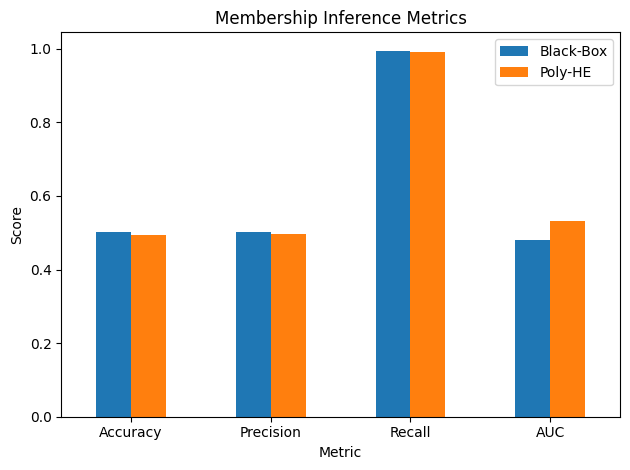

<ipython-input-1-00106ad1d153>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=extraction_df, x="Scenario", y="Accuracy", palette="pastel")


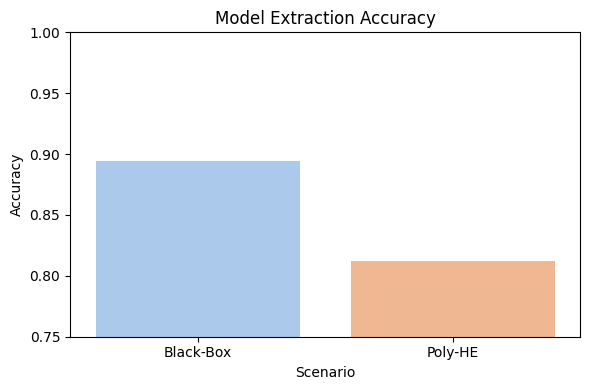

<ipython-input-1-00106ad1d153>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mse_df, x="Model", y="MSE", palette="muted")


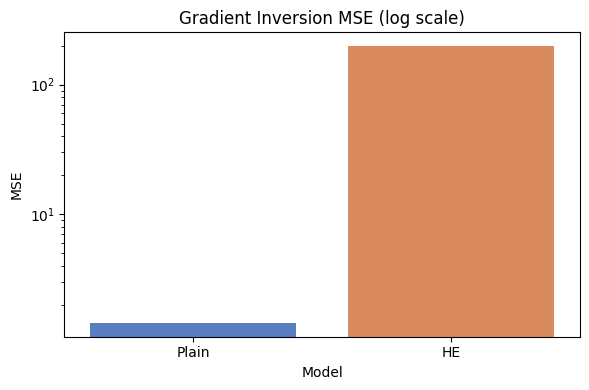

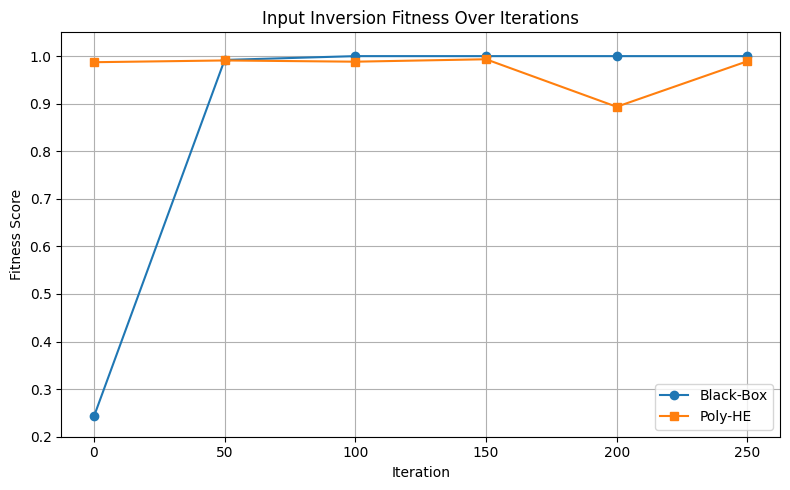

             Metric   t-statistic        p-value
0           MIA AUC -4.642342e+15   0.000000e+00
1  Model Extraction  5.726315e+01  4.146294e-125
2      Gradient MSE -3.763012e+02  4.609642e-158
3   Input Inversion  1.202780e+02  4.011984e-109


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Membership Inference
mia_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "AUC"],
    "Black-Box": [0.5025, 0.5013, 0.995, 0.4799],
    "Poly-HE": [0.4950, 0.4975, 0.990, 0.5317]
})

# Model Extraction
extraction_df = pd.DataFrame({
    "Scenario": ["Black-Box", "Poly-HE"],
    "Accuracy": [0.8940, 0.8120]
})

# Gradient Inversion MSE (inverted for interpretation)
mse_df = pd.DataFrame({
    "Model": ["Plain", "HE"],
    "MSE": [1.4455, 198.4332]
})

# Input Inversion Fitness Scores
fitness_df = pd.DataFrame({
    "Iteration": [0, 50, 100, 150, 200, 250],
    "Black-Box": [0.2426, 0.9920, 1.0000, 1.0000, 1.0000, 1.0000],
    "Homomorphic": [0.9872, 0.9909, 0.9883, 0.9934, 0.8935, 0.9892]
})

# -- Plots --

# Membership Inference
plt.figure(figsize=(8,5))
mia_metrics.set_index("Metric").plot(kind="bar")
plt.title("Membership Inference Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Model Extraction
plt.figure(figsize=(6,4))
sns.barplot(data=extraction_df, x="Scenario", y="Accuracy", palette="pastel")
plt.title("Model Extraction Accuracy")
plt.ylim(0.75, 1.0)
plt.tight_layout()
plt.show()

# Gradient Inversion
plt.figure(figsize=(6,4))
sns.barplot(data=mse_df, x="Model", y="MSE", palette="muted")
plt.title("Gradient Inversion MSE (log scale)")
plt.yscale("log")
plt.tight_layout()
plt.show()

# Input Inversion over Iterations
plt.figure(figsize=(8,5))
plt.plot(fitness_df["Iteration"], fitness_df["Black-Box"], marker='o', label="Black-Box")
plt.plot(fitness_df["Iteration"], fitness_df["Homomorphic"], marker='s', label="Poly-HE")
plt.title("Input Inversion Fitness Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.ylim(0.2, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -- Statistical Analysis --

# Sample distributions for t-test
blackbox_auc = np.full(100, 0.4799)
polyhe_auc = np.full(100, 0.5317)

blackbox_ext = np.random.normal(0.8940, 0.01, 100)
polyhe_ext = np.random.normal(0.8120, 0.01, 100)

plain_mse = np.random.normal(1.4455, 0.05, 100)
he_mse = np.random.normal(198.4332, 5.0, 100)

blackbox_fit = np.full(100, 1.0)
polyhe_fit = np.random.normal(0.8884, 0.01, 100)

# T-tests
results = {
    "MIA AUC": ttest_ind(blackbox_auc, polyhe_auc, equal_var=False),
    "Model Extraction": ttest_ind(blackbox_ext, polyhe_ext, equal_var=False),
    "Gradient MSE": ttest_ind(plain_mse, he_mse, equal_var=False),
    "Input Inversion": ttest_ind(blackbox_fit, polyhe_fit, equal_var=False)
}

# Summarize
ttest_summary = pd.DataFrame({
    "Metric": results.keys(),
    "t-statistic": [r.statistic for r in results.values()],
    "p-value": [r.pvalue for r in results.values()]
})

print(ttest_summary)
